In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from Models.VGG import VGG16

In [3]:
import Utils.Dataset as ds
import Utils.utils as utils

In [4]:
image_classes_paths, classes = utils.get_classes_and_paths()
print(f'Image Classes Paths: {image_classes_paths}\nClasses: {classes}')

Image Classes Paths: ['/Users/Andrew/ml/ImageRecognitionOOTB/Data/TrainImages/LilUziVert', '/Users/Andrew/ml/ImageRecognitionOOTB/Data/TrainImages/Kanye', '/Users/Andrew/ml/ImageRecognitionOOTB/Data/TrainImages/TravisScott']
Classes: ['LilUziVert', 'Kanye', 'TravisScott']


In [5]:
train_indices = []
test_indices = []

for i_class in image_classes_paths:
    
    class_len = len(os.listdir(i_class))
    
    train, val, test = \
        utils.get_indices(class_len, train_percent=0.8, val_percent=0.0, test_percent=0.2)
    
    train_indices.append(train)
    test_indices.append(test)

print(train_indices)
print(test_indices)

[array([0, 1, 2, 3, 5, 6, 7]), array([0, 1, 2, 3, 4, 6, 7]), array([0, 1, 2, 3, 4, 5, 8])]
[array([4, 8]), array([5, 8]), array([6, 7])]


In [6]:
train_set = ds.DataSetCreator(image_classes_paths, train_indices)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)
dataiter = iter(train_loader)

In [7]:
test_set = ds.DataSetCreator(image_classes_paths, test_indices, augment=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=True, num_workers=2)

In [8]:
data_loaders = {'train': train_loader, 'test': test_loader}
print(len(train_loader.dataset))
print(len(test_loader))

21
2


In [9]:
images, labels = dataiter.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


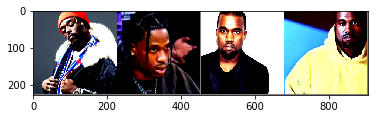

LilUziVert TravisScott Kanye Kanye


In [10]:
utils.show_image(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[int(labels[j].item())] for j in range(4)))

In [11]:
net = VGG16(len(classes), data_loaders)
print(net.net)

TypeError: __init__() missing 1 required positional argument: 'freeze_layers'

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
net.to(device)

if torch.cuda.is_available():
    net.net = torch.nn.DataParallel(net.net)
    criterion = nn.CrossEntropyLoss().cuda()
    dtype = torch.cuda.FloatTensor

else:
    criterion = nn.CrossEntropyLoss()
    dtype = torch.FloatTensor

optimizer = optim.Adam(net.net.parameters())

In [14]:
outputs = net.single_test(images)
print(outputs)

tensor([[ 0.1037, -0.2620,  0.2386],
        [-0.2238, -0.4013,  0.6497],
        [-0.2504,  0.2777,  0.1517],
        [-0.3833, -0.1098, -0.0166]], grad_fn=<ThAddmmBackward>)


# Error w/ loss

In [15]:
net.train(criterion, optimizer, num_epochs=5)


Epoch: 1/5
TRAIN
Percent: [██████████████████████████████ 100.0% 6/6] 21
47.39424180984497
Loss: 2.2568686576116654, Accuracy: 0.3333333333333333
TEST
Percent: [██████████████████████████████ 100.0% 2/2] 6
5.1877100467681885
Loss: 0.8646183411280314, Accuracy: 0.6666666666666666

Epoch: 2/5
TRAIN
Percent: [██████████                     33.33% 2/6] 

Process Process-7:
Process Process-8:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/anaconda3/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeou

RuntimeError: DataLoader worker (pid 29647) exited unexpectedly with exit code 1. Details are lost due to multiprocessing. Rerunning with num_workers=0 may give better error trace.

In [ ]:
plt.plot(net.train_loss_history)

# Debugging

In [49]:
run_loss = 0.0
run_corrects = 0
inputs_total = 0
total = 0

for index, (inputs, targets) in enumerate(data_loaders['train']):
    
    print(index)
    
    with torch.set_grad_enabled(True):
        outputs = net.net(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, targets)
    
    run_loss += loss.item() * inputs.size(0)
    run_corrects += preds.eq(targets).sum().item()
    total += targets.size(0)
    inputs_total += inputs.size(0)


0
1
2
3
4
5


In [50]:
print(f'Inputs Total: {inputs_total}, Total: {total}, Loss: {run_loss}')

Inputs Total: 21, Total: 21, Loss: 24.7510786652565


In [51]:
run_loss = 0.0
run_corrects = 0
inputs_total = 0
total = 0

for index, (inputs, targets) in enumerate(data_loaders['test']):
    
    print(index)
    
    outputs = net.net(inputs)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, targets)
    
    run_loss += loss.item() * inputs.size(0)
    run_corrects += preds.eq(targets).sum().item()
    total += targets.size(0)
    inputs_total += inputs.size(0)


0
1


In [52]:
print(f'Inputs Total: {inputs_total}, Total: {total}, Loss: {run_loss}')

Inputs Total: 6, Total: 6, Loss: 7.092169284820557
